Importing relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from PIL import Image
import time

In [2]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import model_from_json

Reading in the dataset

In [3]:
def readTrafficSigns(rootpath,size=0,grey=False):
    images = [] 
    labels = [] 
    height = []
    width = []

    for c in range(0,43):
        prefix = rootpath + "/" + format(c, "05d") + "/"
        gtFile = open(prefix + "GT-"+ format(c, "05d") + ".csv") 
        gtReader = csv.reader(gtFile, delimiter=";") 
        next(gtReader)

        for row in gtReader:
            im_final = Image.open(prefix + row[0])
            if(size!=0):
                im_final = im_final.resize((size, size), Image.ANTIALIAS)
            if(grey==True):
                im_final=im_final.convert("L")
            images.append(np.array(im_final)) 
            labels.append(row[7])
            height.append(row[2])
            width.append(row[1])
        gtFile.close()
    return images, labels, width, height

In [4]:
data = readTrafficSigns("./GTSRB/Final_Training/Images")

Dataset analysis

In [5]:
width = list(map(int, data[2]))
height = list(map(int, data[3]))
x=0
for i in range(0,len(width)):
    if(width[i]>x):
        x=width[i]
        y=i
print("largest image: "+str(width[y])+"x"+str(height[y]))
for i in range(0,len(width)):
    if(width[i]<=x):
        if(height[i]<=x):
            x=width[i]
            z=i
print("smallest image: "+str(width[z])+"x"+str(height[z]))

largest image: 243x225
smallest image: 25x25


Text(0, 0.5, 'No. of Images')

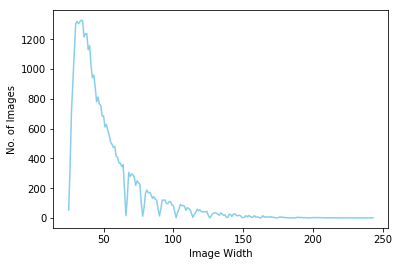

In [6]:
size = pd.DataFrame(width)
size = size[0].value_counts()
size = pd.DataFrame(size)
size = size.sort_index(axis=0)
plt.plot(list(size.index),size[0],color="skyblue")
plt.xlabel ("Image Width")
plt.ylabel ("No. of Images")
#plt.savefig("imgsize.png")

Text(0, 0.5, 'Relative Class Frequency [%]')

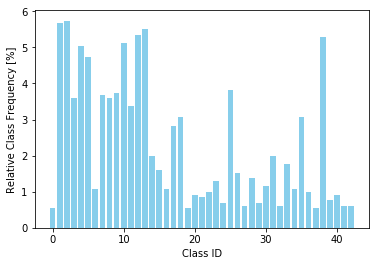

In [7]:
labels = list(map(int, data[1]))
labels = pd.DataFrame(labels)
labels = labels[0].value_counts()
labels = pd.DataFrame(labels)
labels = labels.sort_index(axis=0)
plt.bar(list(labels.index),labels[0]/len(data[1])*100,color="skyblue")
plt.xlabel ("Class ID")
plt.ylabel ("Relative Class Frequency [%]")
#plt.savefig("classdist.png")

In [8]:
print(min(labels[0]))
print(max(labels[0]))

210
2250


Data Preparation

In [9]:
train = readTrafficSigns("./GTSRB/Final_Training/Images",40)
train_grey = readTrafficSigns("./GTSRB/Final_Training/Images",40,True)
train_small = readTrafficSigns("./GTSRB/Final_Training/Images",30)

In [10]:
X=np.array(train[0])
X=X.astype("float32")/255
Y=np.array(train[1])

X_grey=np.array(train_grey[0])
X_grey=X_grey.astype("float32")/255
X_grey = X_grey.reshape(-1,40, 40, 1)

X_small=np.array(train_small[0])
X_small=X_small.astype("float32")/255

In [11]:
model1 = Sequential()
model1.add(Conv2D(16,(3,3), activation = "relu", input_shape=X.shape[1:]))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(32,(3,3), activation = "relu"))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(64,(3,3), activation = "relu"))
model1.add(MaxPooling2D(2,2))
model1.add(Flatten())
model1.add(Dense(64,activation = "relu"))
model1.add(Dense(43,activation = "softmax"))

Instructions for updating:
Colocations handled automatically by placer.


In [34]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 38, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
__________

In [35]:
model1.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
start = time.time()
model1.fit(X, Y, epochs=10)
end = time.time()
model1_time= end-start

Epoch 1/10
39209/39209 [==============================] - 16s 421us/sample - loss: 0.0183 - acc: 0.9952
Epoch 2/10
39209/39209 [==============================] - 16s 404us/sample - loss: 0.0083 - acc: 0.9981
Epoch 3/10
39209/39209 [==============================] - 13s 332us/sample - loss: 0.0170 - acc: 0.9960
Epoch 4/10
39209/39209 [==============================] - 13s 331us/sample - loss: 0.0120 - acc: 0.9968
Epoch 5/10
39209/39209 [==============================] - 13s 332us/sample - loss: 0.0114 - acc: 0.9966
Epoch 6/10
39209/39209 [==============================] - 13s 336us/sample - loss: 0.0108 - acc: 0.9975
Epoch 7/10
39209/39209 [==============================] - 13s 335us/sample - loss: 0.0126 - acc: 0.9966
Epoch 8/10
39209/39209 [==============================] - 13s 336us/sample - loss: 0.0080 - acc: 0.9982
Epoch 9/10
39209/39209 [==============================] - 13s 333us/sample - loss: 0.0087 - acc: 0.9979
Epoch 10/10
39209/39209 [==============================] - 13s 3

In [36]:
model2 = Sequential()
model2.add(Conv2D(16,(3,3), activation = "relu", input_shape=X_grey.shape[1:]))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(32,(3,3), activation = "relu"))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(64,(3,3), activation = "relu"))
model2.add(MaxPooling2D(2,2))
model2.add(Flatten())
model2.add(Dense(64,activation = "relu"))
model2.add(Dense(43,activation = "softmax"))

In [37]:
model2.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

start = time.time()
model2.fit(X_grey, Y, epochs=10)
end = time.time()
model2_time= end-start

Epoch 1/10
39209/39209 [==============================] - 18s 447us/sample - loss: 1.3472 - acc: 0.6436
Epoch 2/10
39209/39209 [==============================] - 17s 433us/sample - loss: 0.2299 - acc: 0.9371
Epoch 3/10
39209/39209 [==============================] - 17s 437us/sample - loss: 0.1159 - acc: 0.9692
Epoch 4/10
39209/39209 [==============================] - 17s 431us/sample - loss: 0.0799 - acc: 0.9778
Epoch 5/10
39209/39209 [==============================] - 17s 431us/sample - loss: 0.0606 - acc: 0.9831
Epoch 6/10
39209/39209 [==============================] - 17s 436us/sample - loss: 0.0451 - acc: 0.9869
Epoch 7/10
39209/39209 [==============================] - 17s 425us/sample - loss: 0.0399 - acc: 0.9887
Epoch 8/10
39209/39209 [==============================] - 17s 434us/sample - loss: 0.0324 - acc: 0.9911
Epoch 9/10
39209/39209 [==============================] - 17s 429us/sample - loss: 0.0309 - acc: 0.9916
Epoch 10/10
39209/39209 [==============================] - 17s 4

In [38]:
model3 = Sequential()
model3.add(Conv2D(16,(3,3), activation = "relu", input_shape=X_small.shape[1:]))
model3.add(MaxPooling2D(2,2))
model3.add(Conv2D(32,(3,3), activation = "relu"))
model3.add(MaxPooling2D(2,2))
model3.add(Conv2D(64,(3,3), activation = "relu"))
model3.add(MaxPooling2D(2,2))
model3.add(Flatten())
model3.add(Dense(64,activation = "relu"))
model3.add(Dense(43,activation = "softmax"))

In [39]:
model3.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
start = time.time()
model3.fit(X_small, Y, epochs=10)
end = time.time()
model3_time= end-start

Epoch 1/10
39209/39209 [==============================] - 9s 227us/sample - loss: 1.3304 - acc: 0.6327
Epoch 2/10
39209/39209 [==============================] - 9s 217us/sample - loss: 0.2172 - acc: 0.9404
Epoch 3/10
39209/39209 [==============================] - 8s 214us/sample - loss: 0.1106 - acc: 0.9697
Epoch 4/10
39209/39209 [==============================] - 8s 211us/sample - loss: 0.0706 - acc: 0.9804
Epoch 5/10
39209/39209 [==============================] - 8s 216us/sample - loss: 0.0518 - acc: 0.9858
Epoch 6/10
39209/39209 [==============================] - 11s 272us/sample - loss: 0.0404 - acc: 0.9889
Epoch 7/10
39209/39209 [==============================] - 9s 234us/sample - loss: 0.0287 - acc: 0.9918
Epoch 8/10
39209/39209 [==============================] - 11s 289us/sample - loss: 0.0308 - acc: 0.9908
Epoch 9/10
39209/39209 [==============================] - 8s 216us/sample - loss: 0.0236 - acc: 0.9933
Epoch 10/10
39209/39209 [==============================] - 8s 215us/sam

In [40]:
model4 = Sequential()
model4.add(Conv2D(32,(3,3), activation = "relu", input_shape=X.shape[1:]))
model4.add(Conv2D(64,(3,3), activation = "relu"))
model4.add(MaxPooling2D(2,2))
model4.add(Conv2D(64,(3,3), activation = "relu"))
model4.add(Conv2D(128,(3,3), activation = "relu"))
model4.add(MaxPooling2D(2,2))
model4.add(Flatten())
model4.add(Dense(128,activation = "relu"))
model4.add(Dropout(rate=0.5))
model4.add(Dense(43,activation = "softmax"))

In [47]:
model4.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

start = time.time()
model4.fit(X, Y, epochs=10)
end = time.time()
model4_time= end-start

Epoch 1/10
39209/39209 [==============================] - 127s 3ms/sample - loss: 1.0924 - acc: 0.6894
Epoch 2/10
39209/39209 [==============================] - 126s 3ms/sample - loss: 0.2372 - acc: 0.9252
Epoch 3/10
39209/39209 [==============================] - 125s 3ms/sample - loss: 0.1339 - acc: 0.9571
Epoch 4/10
39209/39209 [==============================] - 123s 3ms/sample - loss: 0.0930 - acc: 0.9719
Epoch 5/10
39209/39209 [==============================] - 122s 3ms/sample - loss: 0.0715 - acc: 0.9764
Epoch 6/10
39209/39209 [==============================] - 122s 3ms/sample - loss: 0.0571 - acc: 0.9816
Epoch 7/10
39209/39209 [==============================] - 120s 3ms/sample - loss: 0.0498 - acc: 0.9840
Epoch 8/10
39209/39209 [==============================] - 120s 3ms/sample - loss: 0.0446 - acc: 0.9870
Epoch 9/10
39209/39209 [==============================] - 120s 3ms/sample - loss: 0.0371 - acc: 0.9882
Epoch 10/10
39209/39209 [==============================] - 119s 3ms/sampl

In [68]:
print("Building time model 1: "+str(round(model1_time,3))+"s")
print("Building time model 2: "+str(round(model2_time,3))+"s")
print("Building time model 3: "+str(round(model3_time,3))+"s")
print("Building time model 4: "+str(round(model4_time,3))+"s")

Building time model 1: 137.54s
Building time model 2: 170.902s
Building time model 3: 91.751s
Building time model 4: 1227.811s


Saving the models

In [279]:
#model1_json = model1.to_json()
#with open("model1.json", "w") as json_file:
#    json_file.write(model1_json)
#model1.save_weights("model1.h5")

In [278]:
#model2_json = model2.to_json()
#with open("model2.json", "w") as json_file:
#    json_file.write(model2_json)
#model2.save_weights("model2.h5")

In [277]:
#model3_json = model3.to_json()
#with open("model3.json", "w") as json_file:
#    json_file.write(model3_json)
#model3.save_weights("model3.h5")

In [276]:
#model4_json = model4.to_json()
#with open("model4.json", "w") as json_file:
#    json_file.write(model4_json)
#model4.save_weights("model4.h5")

Reading the models again

In [11]:
json_file = open("model1.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model1_load = model_from_json(loaded_model_json)
model1_load.load_weights("model1.h5")

json_file = open("model2.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model2_load = model_from_json(loaded_model_json)
model2_load.load_weights("model2.h5")

json_file = open("model3.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model3_load = model_from_json(loaded_model_json)
model3_load.load_weights("model3.h5")

json_file = open("model4.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model4_load = model_from_json(loaded_model_json)
model4_load.load_weights("model4.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Testing the models

In [13]:
def readTestSigns(rootpath,size=0,grey=False):
    images = []
    labels = []
    width = []
    gtFile = open(rootpath + "/GT-final_test.csv")
    gtReader = csv.reader(gtFile, delimiter=";")
    next(gtReader)
    for row in gtReader:
        im_final = Image.open(rootpath + "/" + row[0])
        if(size!=0):
            im_final = im_final.resize((size, size), Image.ANTIALIAS)
        if(grey==True):
            im_final=im_final.convert("L")
        images.append(np.array(im_final)) 
        labels.append(row[7])
        width.append(row[1])
    gtFile.close()
    return images, labels, width

In [14]:
test = readTestSigns("./GTSRB/Final_Test/Images",40)
test_grey = readTestSigns("./GTSRB/Final_Test/Images",40,grey=True)
test_small = readTestSigns("./GTSRB/Final_Test/Images",30)

In [15]:
X_test=np.array(test[0])
X_test=X_test.astype("float32")/255
Y_test=np.array(test[1])

X_test_grey=np.array(test_grey[0])
X_test_grey=X_test_grey.astype("float32")/255
X_test_grey = X_test_grey.reshape(-1,40, 40, 1)

X_test_small=np.array(test_small[0])
X_test_small=X_test_small.astype("float32")/255

In [16]:
truth= np.array(list(map(int,test[1])))

Predictions

In [17]:
times = []
predictions = []
accuracies = []
s = time.time()
pred = model1_load.predict_classes(X_test)
e=time.time()
times.append((e-s)/12630*1000)
predictions.append(pred)
accuracies.append(sum(pred==truth)/len(truth))

s = time.time()
pred = model2_load.predict_classes(X_test_grey)
e=time.time()
times.append((e-s)/12630*1000)
predictions.append(pred)
accuracies.append(sum(pred==truth)/len(truth))

s = time.time()
pred = model3_load.predict_classes(X_test_small)
e=time.time()
times.append((e-s)/12630*1000)
predictions.append(pred)
accuracies.append(sum(pred==truth)/len(truth))

s = time.time()
pred = model4_load.predict_classes(X_test)
e=time.time()
times.append((e-s)/12630*1000)
predictions.append(pred)
accuracies.append(sum(pred==truth)/len(truth))

Analysis

In [18]:
print("Accuracies of models 1-4")
accuracies

Accuracies of models 1-4


[0.9478226444972289,
 0.9342042755344419,
 0.9255740300870943,
 0.9768804433887569]

In [19]:
print("Prediction Time per sample in ms:")
times

Prediction Time per sample in ms:


[0.12243947431574902,
 0.10265801883555553,
 0.07544753104094372,
 1.3513846521989183]

Focus on model 4

In [20]:
pred = predictions[3]
acc = accuracies[3]

In [21]:
recall = []
precision = []
for i in range (0,43):
    a=truth[truth==i]
    b=pred[truth==i]
    c=truth[pred==i]
    d=pred[pred==i]
    recall.append(round(sum(a==b)/len(a),3))
    precision.append(round(sum(c==d)/len(c),3))

Text(0, 0.5, 'Recall/Precision/Instances[x/max]')

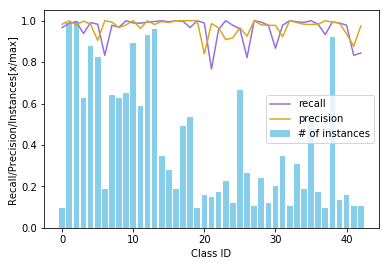

In [22]:
plt.plot(recall,color="mediumpurple")
plt.plot(precision,color="goldenrod")
plt.bar(list(labels.index),labels[0]/max(labels[0]),color="skyblue")
leg = plt.legend(["recall","precision","# of instances"],loc=5)
plt.xlabel ("Class ID")
plt.ylabel ("Recall/Precision/Instances[x/max]")
#plt.savefig("acc_and_class.png")

In [23]:
recall_class = pd.DataFrame(data=[recall,precision,labels[0]])
recall_class = recall_class.transpose()
recall_class.columns = ["recall","precision","amount"]

In [24]:
recall_class.sort_values(by="recall").head()

,recall,precision,amount
21,0.767,0.986,330.0
26,0.822,0.925,600.0
41,0.833,0.877,240.0
6,0.833,1.000,420.0
42,0.844,0.974,240.0


In [25]:
recall_class.sort_values(by="precision").head()

,recall,precision,amount
20,0.989,0.840,360.0
41,0.833,0.877,240.0
5,0.983,0.905,1860.0
23,1.000,0.909,510.0
24,0.978,0.917,270.0


In [26]:
p = pd.Series(list(map(int,pred)))
t = pd.Series(list(map(int,Y_test)))
confmat = pd.crosstab(t, p,rownames=["Actual"], colnames=["Predicted"])
confmat = confmat/confmat.sum(axis=1)

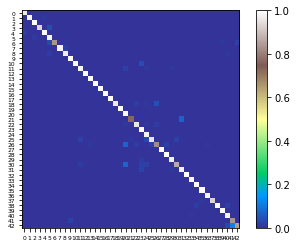

In [27]:
ticks=np.linspace(0, 42,num=43)
plt.imshow(confmat, interpolation="none",cmap="terrain")
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(False)
plt.show()
#plt.savefig("confmat.png")

In [28]:
size_acc = pd.DataFrame(data=[list(map(int,test[2])),pred==truth])
size_acc = size_acc.transpose()

In [30]:
size = []

for i in range (0,len(pred)):
    if size_acc[0][i] <31:
        size.append(1)
    else:
        if size_acc[0][i] <51:
            size.append(2)
        else:
            if size_acc[0][i] <100:
                size.append(3)
            else:
                size.append(4)
size_acc[2]=size

In [31]:
size_acc_1 = size_acc[size_acc[2]==1]
size_acc_2 = size_acc[size_acc[2]==2]
size_acc_3 = size_acc[size_acc[2]==3]
size_acc_4 = size_acc[size_acc[2]==4]

In [32]:
print(round(sum(size_acc_1[1])/len(size_acc_1),3))
print(round(sum(size_acc_2[1])/len(size_acc_2),3))
print(round(sum(size_acc_3[1])/len(size_acc_3),3))
print(round(sum(size_acc_4[1])/len(size_acc_4),3))

0.94
0.983
0.984
0.965


Text(0, 0.5, 'Recall')

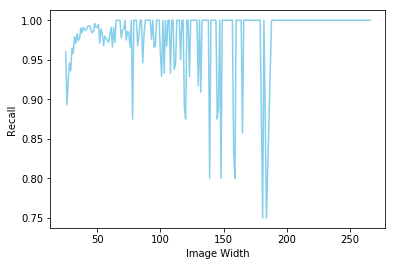

In [34]:
recall_size_class = []
twidth = size_acc[0]
for i in list(size_acc[0].sort_values().unique()):
    a=truth[twidth==i]
    b=pred[twidth==i]
    recall_size_class.append(round(sum(a==b)/len(a),3))
plt.plot(list(size_acc[0].sort_values().unique()),recall_size_class,color="skyblue")
plt.xlabel ("Image Width")
plt.ylabel ("Recall")
#plt.savefig("Recall_Size.png")